In [1]:
!pip install summarytools

In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from summarytools import dfSummary
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import random
from scipy.optimize import minimize
from colorama import Style, Fore
from sklearn.calibration import CalibrationDisplay
import math
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv
/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv


# Data

In [3]:
%%time
train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv',index_col='id')
test =  pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv',index_col='id')
original = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

CPU times: user 793 ms, sys: 128 ms, total: 921 ms
Wall time: 1.19 s


In [4]:
train.head(3)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1


In [5]:
dfSummary(train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Name[object],1. Rohan2. Aarav3. Rupak4. Aaradhya5. Anvi6. Raghavendra7. Vani8. Tushar9. Ritvik10. Shiv11. other,"3,178 (2.3%)2,336 (1.7%)2,176 (1.5%)2,045 (1.5%)2,035 (1.4%)1,877 (1.3%)1,657 (1.2%)1,596 (1.1%)1,589 (1.1%)1,568 (1.1%)120,643 (85.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAECklEQVR4nO3cQWobZwCG4V9GuNFGQhh0DB9Ah+hhewgdwPcQRrOI3GzURW3jlEKhaF7V7vNsQgQRs3gZMcP/ZXG5XAYU7m59Afx/iI2M2MiIjYzYyIiNjNjIiI2M2MgsxhirMcb9h89+XC6X842uhy9s+fDw8Ot6vd6+fTBN0/NisfhNcFzbcr1eb/f7/Xmz2bycTqdvh8Nhezwe78cYYuOqlmOMsdlsXna73ffXz1Y3vB6+MA8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGZjnGGKfT6dvHP2EOy2mang+Hw3a8nmObpul5jPHjtpfFV2SDQGbhv8yi8tc7m7sas/lpXWVZxZzu3tZV+/3+/Brd/T/+K/gX3tdVr3+3rGI2XuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR+WnwAnP6OHgxdmFWjoWTMXgh8/HO5q7GrN4HL8YuzO1uvV5vHx8fh7ELc7sbY4zVavX7rS+Er89LXTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJ3Y4xxPp9/ufWF8PXdTdP0/PT0ZOzC7BwLJ2PwQsYDAhk/o2Ssq8hYV5GxriLjAYGM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MdRUZ6yoyjoWTsa4i485GxuCFjMELGYMXMl7qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IWPwQsaxcDIGL2Tc2cgYvJAxeCFj8ELGS10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNjXUXGuoqMDQIZ6yoy7mxkrKvIWFeRsa4i46UuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGYMXMgYvZBwLJ2PwQsadjYzBCxmDFzIGL2S81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELG4IWMY+FkDF7IeEAg42eUjHUVGesqMtZVZDwgkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbGuImNdRcaxcDLWVWTc2cgYvJAxeCFj8ELGS10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOBZOxuCFzMc7G7yZ5VfuffBy7S/m85pr/LRcr9fb/X5/3mw2L9f8Yj6n0+n07XA4bI/H4/0Y47qxjTHGZrN52e1236/5xXxqqzm+1EtdMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2Mssx/jxWcusL4b9hzhaW0zQ9Hw6H7ZjpWAmfz1zjJ8fC+TuzHAs3eCHjAYGM2MiIjYzYyIiNjNjIiI2M2MiIjcwfLsDJnF8TG+UAAAAASUVORK5CYII="">",0(0.0%)
2,Gender[object],1. Male2. Female,"77,464 (55.1%)63,236 (44.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bQWrDMBRF0a8iQjORMAYvxovoYrsI7cYYa9CETNRBJy1YM/nJuPes4GMuhgQ/V0oxQMGZ2d3Mbr0PuZhXKeXR+4iz8eM4foQQht6HXEnOeXXOfRLcXz6EMMzz/IgxPnsfcwXbtr2nlIZlWW5mRmy/eDOzGONzmqav3sdcyL33AWf01vsA/B/EBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIeLOfD/56H3IVPMs6n3NeU0qD8cFfMznn1cxeve84GwYvx2DwssMx5YMKb7Y63k6NMeWrYI7XHlO+HczxjsGUr45f543xpy5kiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskGHKt4PncQymfBXM8dpj8FLH4KWxbwpbat/D6U2YAAAAAElFTkSuQmCC"">",0(0.0%)
3,Age[float64],Mean (sd) : 40.4 (12.4)min < med < max:18.0 < 42.0 < 60.0IQR (CV) : 22.0 (3.3),43 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACnklEQVR4nO3cy27aQBSA4TMlIAOqEaKCHS9QqQuWbPoGfdhuu+uCvABvwAYhIS7CjYUx7qatVClcPGbiOZP/26JJrOjXZHw0iSmKQgDffaj7AYB7PNX9AAiHMaYtIi3L5ceiKF4ufUioeAhjTHswGHyL47hvs36/32+MMd8vxUqoeJRWHMf96XT60uv10jILd7tdNJvN+uv1uiUihAr3er1eOhwOf1ksbV/7kJcpqECoUIFQoQKhQgVephxwOU98rwj1wVzPE98rQn08p/PEW0LdzQnVEVfzxGtC3s0JNSy17uYuEWqA6tjNXbsZaqhnHl/led4UkdgYY7M8Pp/PzQc/kheuhhrymcdHSZI0syz7Mh6PG41Go9SvbhGRLMuiPM8/p2n6U0RsdlRv3dpRgz3z+Oh4PD5FUdSZTCbpaDTalF2/WCz68/m8czqdGi6er053nVFDPPP4rNvtWv28N5tNsD9vXqbwj8/nY0KFiPh/PiZUiIj/52NCxX98PR8T6gUV5sfBzjLrRKivqDI/DnmWWSdCfZ31/DjkWWadCPUKm/lxyLPMOvGnKFDB6Y5acYAswqUW/OEs1KoDZBGR7XZ7MMb8EBGb9UQeEGehVh0gL5fLj8/Pz1/H4/Enm9C5uRUW5y9TVQbItqFzcys83r/124ae53ksnl6wQHneh2rD9wsWKC/IUH2/YIHyggz1L18vWKA8Bv5QgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqHDXP/Ld7XZR2S98OBwiEZEkSaLVatV5y/Vav7fW5666/p6+fgMirq0FBGkPcQAAAABJRU5ErkJggg=="">",0(0.0%)
4,City[object],1. Kalyan2. Patna3. Vasai-Virar4. Kolkata5. Ahmedabad6. Mee

* Numerical variables with little distinction in values, we can use them as categories.
* we have features with null values and no duplicate records.

In [6]:
TARGET = 'Depression'
NUM_COLS = ['CGPA','Age']
CAT_COLS = [f for f in test.columns if f not in (NUM_COLS)]    
SUBMIT = True

# Features

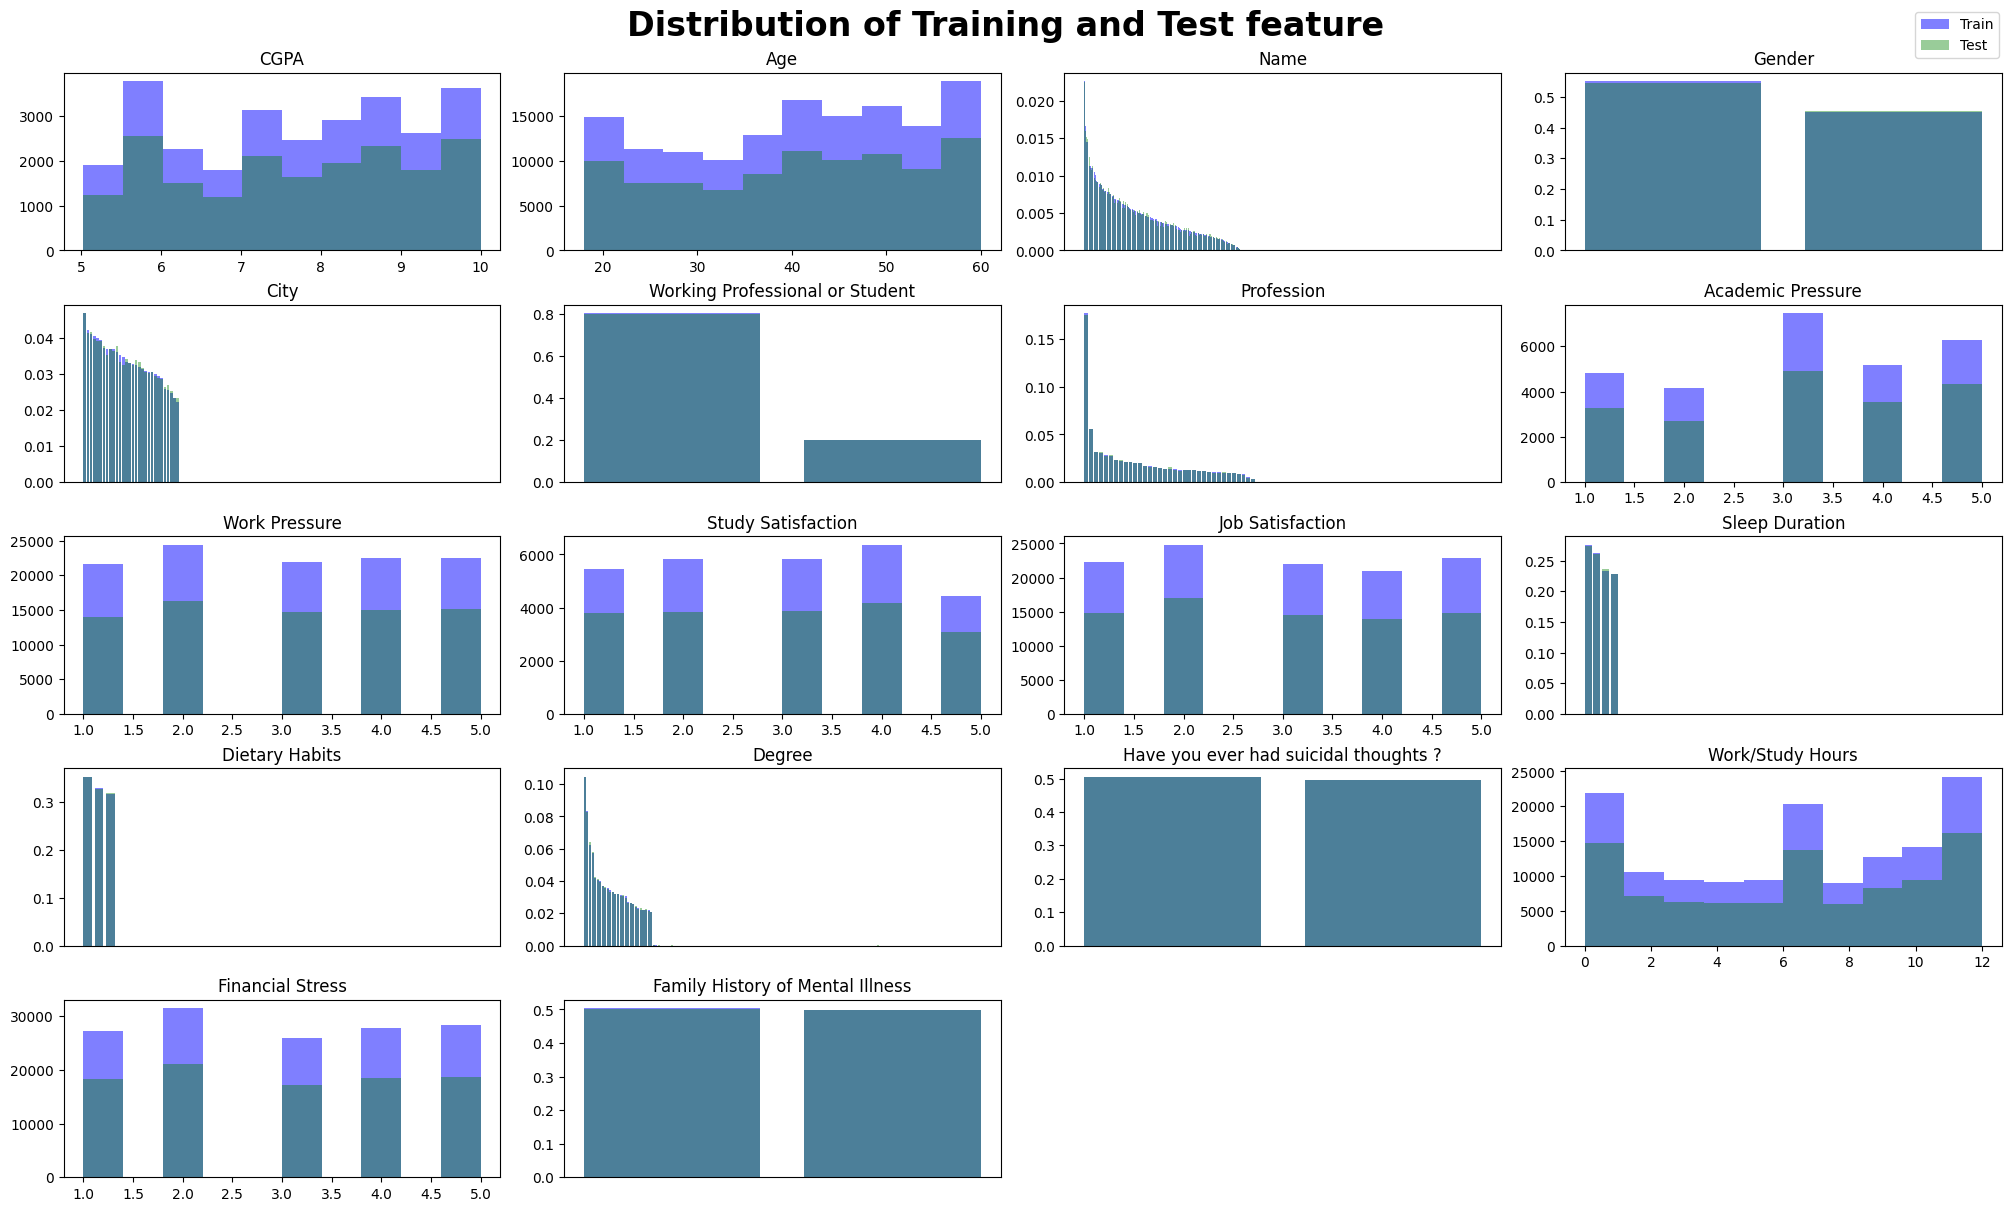

In [7]:
fig, axs = plt.subplots(5,4,figsize=(20,12), constrained_layout=True)
for  (col,ax) in zip(NUM_COLS+CAT_COLS,axs.ravel()):   
    if train[col].dtype in ('category','object'):
        vc = train[col].value_counts()/len(train)
        vc_test = test[col].value_counts()/len(test)
        ax.bar(vc.index.astype(str),vc, color='blue',alpha=0.5,label='train')
        ax.bar(vc_test.index.astype(str), vc_test,color='green',alpha=0.4,label='test')
        ax.set_xticks([])
    if train[col].dtype=='float':
        ax.hist(train[col],color='blue',alpha=0.5,label='Train')
        ax.hist(test[col],color='green',alpha=0.4,label='Test')
    ax.set_title(f'{col}')
for ax in axs.ravel():
    if not ax.has_data():
        ax.axis('off')  
fig.legend(bbox_to_anchor=[1,1],labels=['Train','Test'])
plt.suptitle('Distribution of Training and Test feature',fontweight='bold',size=24);



# Target

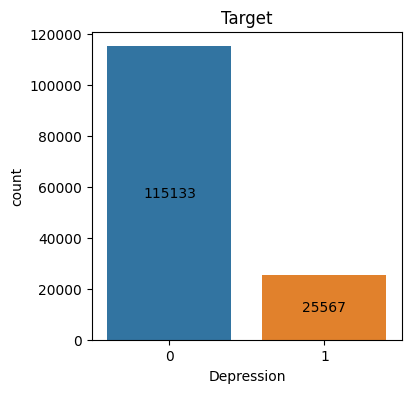

In [8]:
fig = plt.figure(figsize=(4,4))
ax = sns.countplot(train,x=TARGET)
ax.bar_label(ax.containers[0],label_type='center')
ax.set_title('Target');

* accuracy is not good for unbalanced classes.

In [9]:
train['is_test'] = 0
test['is_test'] = 1
df = pd.concat([train,test],axis=0)
for c in CAT_COLS :        
    df[c] = df[c].fillna('-1')
    df[c] = df[c].astype('category')              
    mapping = df[c].value_counts().to_dict()
    code_as = 0
    for i, key in enumerate(reversed(mapping)):
        mapping[key] = code_as
        code_as += 1
    df[c] = df[c].map(mapping)
    df[c] = df[c].astype('int')
for n in NUM_COLS:
    df[n] = df[n].interpolate()
    df[n] = df[n].bfill()
train = df[df['is_test']==0]
test = df[df['is_test']==1]

# Model

In [10]:
def get_model():
    data = df.copy()
    inputs  = []
    outputs = []
    ci = 0
    for c in CAT_COLS:
        ci += 1
        emd_dim = int(math.sqrt(data[c].nunique()+1))
        inp = keras.layers.Input(shape=(1,))        
        out = keras.layers.Embedding(data[c].nunique()+1, emd_dim, name=str(ci))(inp)
        out = keras.layers.SpatialDropout1D(0.3)(out)
        out = keras.layers.Reshape(target_shape=(emd_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)

    inp_num = keras.layers.Input(shape=(len(NUM_COLS),), name='numeric_input')
    inputs.append(inp_num)

    x = keras.layers.Concatenate(axis=-1)(outputs+[inp_num])
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(300, activation="relu")(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(300, activation="relu")(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.BatchNormalization()(x)

    y = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=y)

    model.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.BinaryCrossentropy,
                 metrics=['auc','accuracy'])       

    keras.utils.plot_model(model)
    return model
                                  

In [11]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
preprocess = make_pipeline(ColumnTransformer([('num',StandardScaler(),NUM_COLS)],
                                            remainder='passthrough',
                                            verbose_feature_names_out=False)).set_output(transform='pandas')
oof = {}
test_preds = {}
def cross_val_nn(plot=False):
    X = train.copy()
    y = X.pop(TARGET)
    score_log_loss = []
    score_auc = []
    score_acc = []
    
    val_preds = np.zeros((len(X)))
    test_p = np.zeros((len(test)))
    
    for fold, (trx_idx, val_idx) in enumerate(kf.split(X,y)):
        print(f'{Fore.BLUE}{Style.BRIGHT}****** FOLD: {fold+1} ****** {Style.RESET_ALL}')
        X_train = X.iloc[trx_idx]
        y_train = y.iloc[trx_idx]
        
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        X_train = preprocess.fit_transform(X_train)          
        X_val = preprocess.transform(X_val)
        X_test = preprocess.transform(test)
        
        model = get_model()
       
        X_train_num = X_train[NUM_COLS].to_numpy()
        X_train_cat = X_train[CAT_COLS].to_numpy()
        X_train_cat = [X_train_cat[:,k] for k in range(X_train_cat.shape[1])]    
           
        X_val_num = X_val[NUM_COLS].to_numpy()
        X_val_cat = X_val[CAT_COLS].to_numpy()
        X_val_cat = [X_val_cat[:, k] for k in range(X_val_cat.shape[1])]
    
                   
        X_test_num = X_test[NUM_COLS].to_numpy()
        X_test_cat = X_test[CAT_COLS].to_numpy()
        X_test_cat = [X_test_cat[:, k] for k in range(X_test_cat.shape[1])]
        
        
        es = keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=4,
                                     verbose=1, baseline=None, restore_best_weights=False)
    
        rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                          patience=2, min_lr=1e-6, mode='max', verbose=1)
        
        hist= model.fit([X_train_cat,X_train_num], y_train.values, 
                  validation_data=([X_val_cat,X_val_num],y_val.values),
                  batch_size=32,   
                  callbacks=[rlr],
                  epochs=12)
        y_pred = model.predict([X_val_cat,X_val_num]).flatten()    
        y_pred_int = np.where(y_pred>0.5,1,0)
        
        y_pred_test = model.predict([X_test_cat,X_test_num]).flatten()         
        score_log_loss.append(log_loss(y_val, y_pred))
        score_auc.append(roc_auc_score(y_val, y_pred))  
        score_acc.append(accuracy_score(y_val, y_pred_int))
        val_preds[val_idx] += y_pred       
        test_p += y_pred_test / kf.get_n_splits()
        
    oof['NN'] = val_preds
    test_preds['NN'] = test_p    
    print(f'{Fore.GREEN}{Style.BRIGHT}Log Loss: {np.mean(score_log_loss)} | AUC: {np.mean(score_auc)} | Accuracy: {np.mean(score_acc)} {Style.RESET_ALL}')


cross_val_nn()

****** FOLD: 1 ****** 
Epoch 1/12
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.8822 - auc: 0.9218 - loss: 0.2776 - val_accuracy: 0.9364 - val_auc: 0.9729 - val_loss: 0.1583 - learning_rate: 0.0010
Epoch 2/12
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.9201 - auc: 0.9582 - loss: 0.1932 - val_accuracy: 0.9370 - val_auc: 0.9734 - val_loss: 0.1592 - learning_rate: 0.0010
Epoch 3/12
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.9217 - auc: 0.9585 - loss: 0.1926 - val_accuracy: 0.9378 - val_auc: 0.9733 - val_loss: 0.1556 - learning_rate: 0.0010
Epoch 4/12
3514/3518 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9236 - auc: 0.9610 - loss: 0.1870
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9236 - auc: 0.9610 - loss: 0.1870 - val_accuracy: 0.9365 - val_auc: 0.9734 - val_loss: 0.1550 - learning_rate: 0.0010
Epoch 5/12
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accur

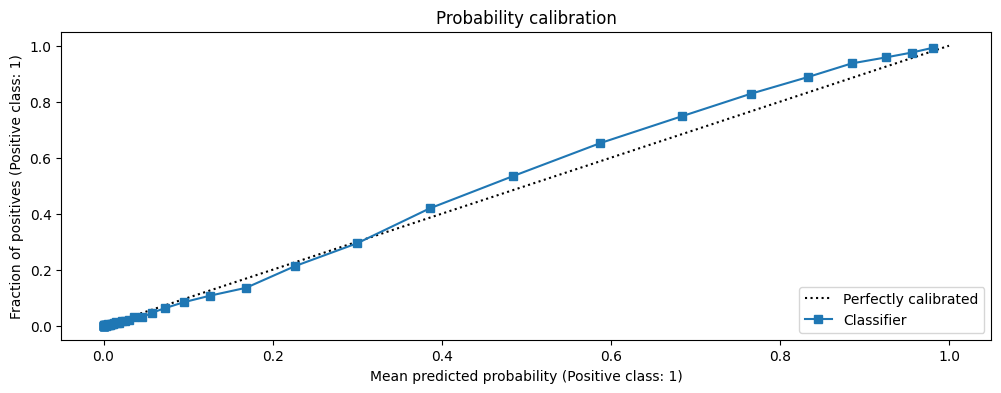

In [12]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(train[TARGET], oof['NN'], n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

* The graph below indicates that the classifier is well-calibrated.

* Diagonal line: The diagonal black line represents a perfectly calibrated classifier. This means that for a given probability value predicted by the model, the actual proportion of positive examples in that class is exactly the same as the predicted probability.

* Fitting points: The blue points, which represent the classifier, are close to the diagonal line. This indicates that the probabilities predicted by the model are well-calibrated with the actual frequencies of the positive class.

# Submission

In [13]:
if SUBMIT:
    sub = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
    sub['Depression'] = np.where(test_preds['NN']>0.45,1,0)
    sub.to_csv('submission.csv',index=False)    

## Threshold

* Nelder-Mead is an effective optimization algorithm that can be used to optimize the decision threshold in classification problems.

In [14]:
def negative_accuracy(threshold):
    y_pred = (oof['NN']> threshold).astype(int)
    y_true = train[TARGET]
    return -accuracy_score(y_true,y_pred)

result = minimize(negative_accuracy, x0=0.5, bounds=[(0,1)], method='Nelder-Mead')
best_threshold = result.x[0]
print(f'best threshold: {best_threshold} - Accuracy: {accuracy_score(train[TARGET],np.where(oof["NN"]>best_threshold,1,0))}')

best threshold: 0.48164062500000004 - Accuracy: 0.9393248045486852
